# 8장 딥러닝

https://github.com/WegraLee/deep-learning-from-scratch

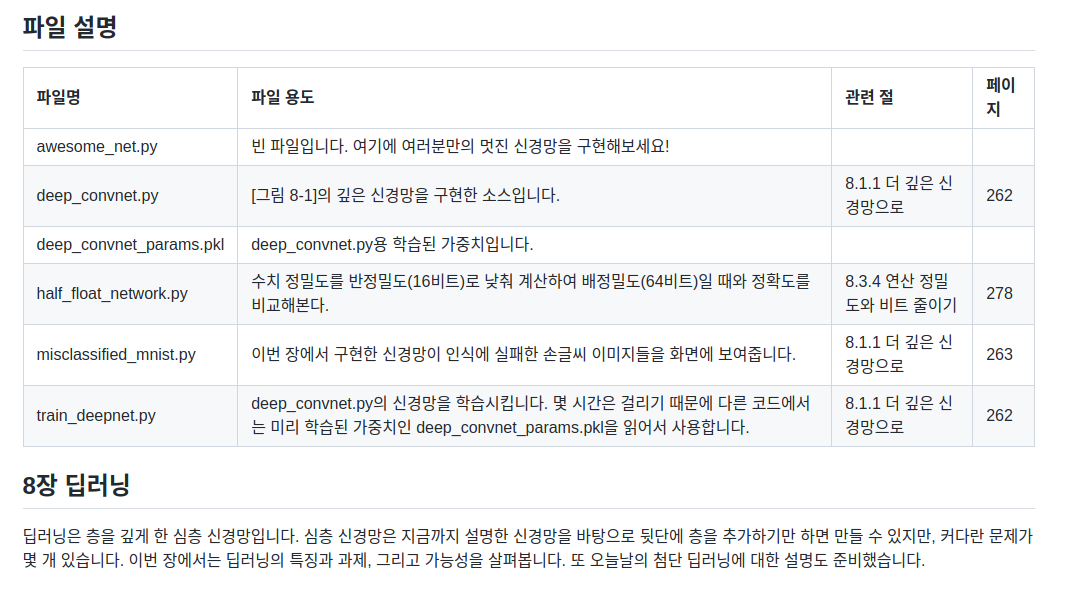

딥러닝 : 층을 깊게 한 심층 신경망
- 지금까지 설명한 신경망을 바탕으로 뒷단에 층을 추가하면 만들 수 있지만, 커다란 문제가 몇 개 있음
- 딥러닝의 특징과 과제, 그리고 가능성에 대하여 살핌
- 오늘날의 딥러닝 설명

## 8.1 더 깊게


그동안 배운 기술을 집약하고 심층 신경망을 말들어 MNIST 데이터셋의 손글씨 숫자인식에 도전

### 8.1.1 더 깊은 네트워크로

아래와 같이 구성된 CNN을 만들고자 한다.(VGG 신경망 참고)

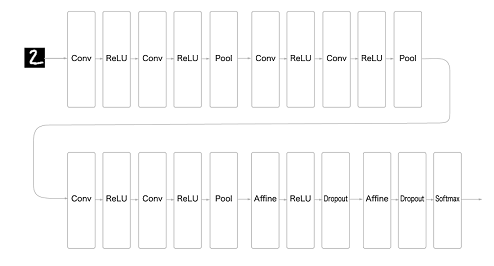

모두 3x3 크기의 작은 필터 적용

층이 깊어지면서 채널 수가 늦어나는 것이 특징(16, 16, 32, 32, 64, 64)

풀링 계층을 추가하여 중간 데이터의 공간 크기를 점차 줄여감

마지막 단의 완전 계층에서는 드롭아웃 계층 사용

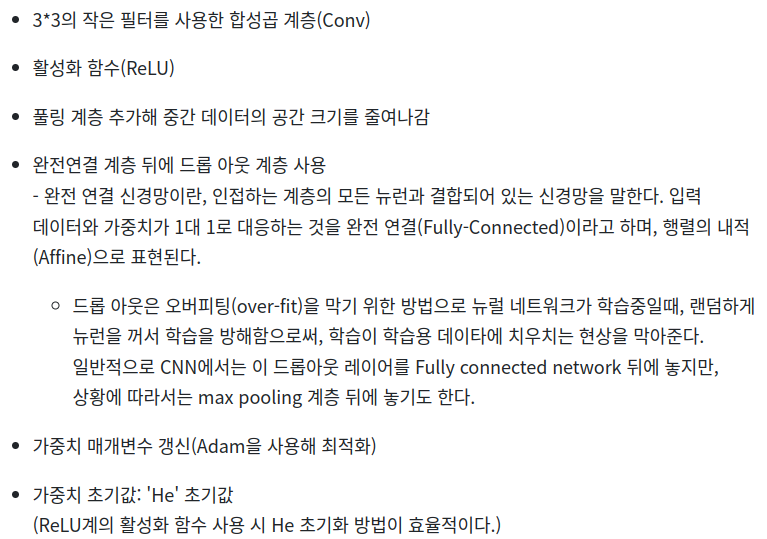

In [ ]:
import numpy as np

In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).

    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    # (N, out_h, out_w, C, filter_h, filter_w)
    # column N*out_h*out_w , -1 로 정렬
    return col

In [ ]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 중간 데이터（backward 시 사용）
        self.x = None
        self.col = None
        self.col_W = None

        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None


    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
#from common.layers import *
#from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망

    conv - relu - pool - affine - relu - affine - softmax

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [ ]:
def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

In [ ]:
 def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx


In [ ]:
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [ ]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.001):
        self.lr = lr

    #params = 가중치 / grads = 기울기
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [ ]:
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.001, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    # v는 초기화x , update 호출시 매개변수와 같은 구조의 데이터 딕셔너리로 저장
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [ ]:
class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [ ]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            # 1e-7 은 0으로 나누지 않게하는 값

In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


In [ ]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.

    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [ ]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask



deep_convnet.py

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
#from common.layers import *


class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값

        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'],
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'],
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'],
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

이것은 Python에서 심층 합성곱 신경망(ConvNet)을 구현한 것입니다. 네트워크의 아키텍처는 ReLU 활성화, 풀링 계층, 완전히 연결된(아핀) 계층 및 드롭아웃 계층이 뒤따르는 여러 컨볼루션 계층으로 구성됩니다. 네트워크의 아키텍처는 이미지 분류 작업에서 높은 정확도를 달성하도록 설계되었습니다. 네트워크는 각 계층의 뉴런 간 연결 수에 따라 조정되는 임의의 가중치와 편향으로 초기화됩니다. 네트워크의 계층은 Convolution 및 Relu와 같은 사용자 지정 클래스의 인스턴스로 정의되며 네트워크가 구성될 때 생성되고 목록에 저장됩니다.

train_deepnet.py

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
#from dataset.mnist import load_mnist
#from deep_convnet import DeepConvNet
#from common.trainer import Trainer

#(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
import tensorflow as tf
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255
x_train = x_train / 255
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

network = DeepConvNet()
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  #epochs=20, mini_batch_size=100,
                  epochs=1, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

train loss:2.268770141535906
=== epoch:1, train acc:0.13, test acc:0.142 ===
train loss:2.3129274643007376
train loss:2.3041212365270134
train loss:2.332173720194194
train loss:2.2865963546665795
train loss:2.3002648154023557
train loss:2.2844454742152767
train loss:2.2754455642982774
train loss:2.261713529842505
train loss:2.2652142012437664
train loss:2.2924410881164117
train loss:2.252266524486815
train loss:2.246491751395524
train loss:2.2370401003063547
train loss:2.259068082618486
train loss:2.2840281873898705
train loss:2.2289014008000545
train loss:2.2164647226750565
train loss:2.1939862433742867
train loss:2.1670313693795653
train loss:2.1808178375015106
train loss:2.1043364948381833
train loss:2.1620456614023036
train loss:2.096628912537845
train loss:2.1326459670426696
train loss:2.032523288231971
train loss:2.141149909718978
train loss:2.117553344285813
train loss:2.07485981620877
train loss:2.0871397085908576
train loss:2.0322715282377106
train loss:1.9273577142182878
trai

epochs  1인 경우 : 98.11%

epochs 20인 경우 : 98.38%

0.62%의 잘못 인식할 확률
- 어떤 이미지를 인식하지 못했는지 살펴 본다.

misclassified_mnist.py

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
#from deep_convnet import DeepConvNet
#from dataset.mnist import load_mnist


#(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
import tensorflow as tf
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255
x_train = x_train / 255
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)

acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()

max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])

        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()

### 8.1.2 정확도를 더 높이려면

앙상블 학습, 학습률 감소, 데이터 확장 : 정확도 향상에 공헌

데이터 확장(data augmentation)은 손쉬운 방법이면서도 정확도 개선에 매우 효과적임

데이터 확장은 입력 이미지를 알고리즘을 동원해 인위적으로 확장
- 회전, 세로로 이동 등 미세 변화를 주어서 이미지 갯수를 늘림

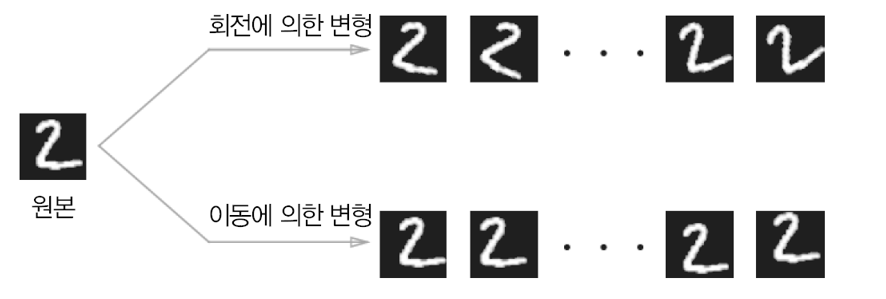

crop, flip, 이미지의 밝기 등의 외형 변화나 확대/축소 등의 스케일 변화도 효과적임

### 8.1.3 깊게 하는 이유

ILSVRC로 대표되는 대규모 이미지 인식 대회의 결과
- 최근 상위를 차지한 기법 대부분은 딥러닝 기반
- 층의 깊이에 비례해 정확도가 좋아짐

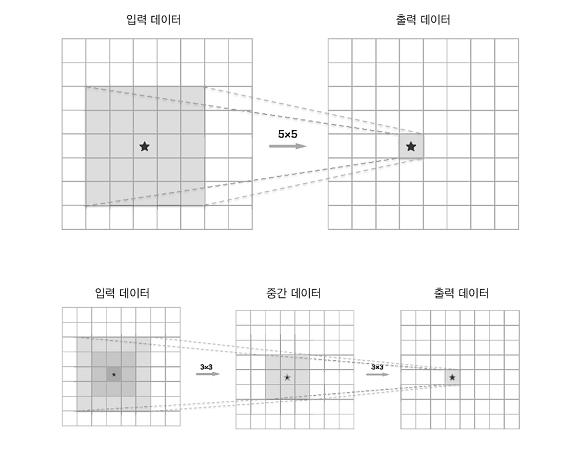

층을 깊게할 때 이점 :신경망의 매개 변수의 수가 줄어든다.
- 5x5와 3x3 3x3의 예
- 7x7와 3x3 3x3 3x3의 예

학습의 효율성
- 층을 깊게 함으로써 학습 데이터의 양을 줄여 학습을 고속으로 수행
- CNN의 합성곱 계층이 정보를 계층적으로 추출
  - 앞단 에지 등의 단순한 패텅에 뉴런이 반응
  - 깊어지면서 텍스처와 사물의 일부와 같이 점차 복잡한 것에 반응
- 개 인식문제
  - 얕은 신경망에서 해결하려면 합성곱 계층은 개의 특징 대부분을 한번에 이해해야 한다.
    - 견종도 다양하고 어느 각도에서 찍은 사진이냐에 따라 완전히 다르게 보일 수 있음
    - 개의 특징을 이해하려면 변화가 풍부하고 많은 데이터가 필요 - 결과적으로 학습 시간이 오래 걸림
  - 심층 신경망 : 학습해야 할 문제를 계층적으로 분해할 수 있음
    - 각 층이 학습해야 할 문제를 더 단순한 문제로 대체할 수 있음

## 8.2 딥러닝의 초기 역사

### 8.2.1 이미지넷

대표적인 신경망


### 8.2.2 VGG

합성곱 계층과 풀링 계층으로 구성되는 기본적인 CNN
비중 있는 층(합성곱 계층, 완전연결 계층)을 모두 16층(혹은 19층)으로 심화함.

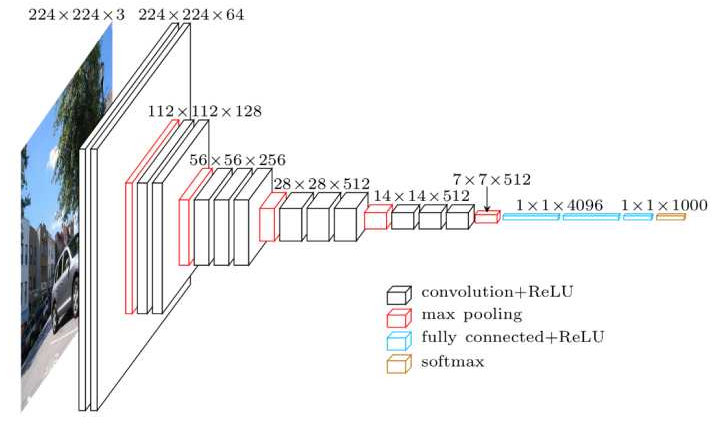

3*3의 작은 필터를 사용한 합성곱 계층을 연속으로 거친다.
합성곱 계층을 2~4회 연속으로 풀링 계층을 두어 크기를 절반으로 줄이는 처리를 반복하고 마지막에는 완전연결 계층을 통과시켜 결과를 출력한다.

### 8.2.3 GoogLeNet

기본적으로는 기존의 CNN과 다르지 않지만 세로 방향 깊이 뿐 아니라 가로 방향도 깊다는 점이 특징이다.
GoogLeNet에는 가로 방향에 폭이 있고 이를 인셉셥 구조라 한다.

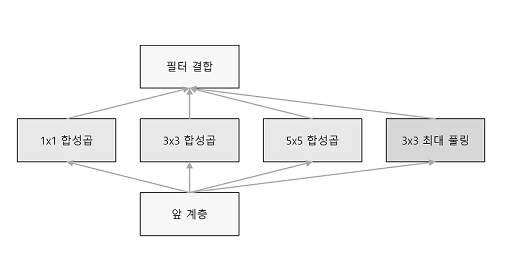

인셉션 구조는 크기가 다른 필터(와 풀링)을 여러 개 적용하여 그 결과를 결합하는데 GoogLeNet은 이 인셉션 구조를 하나의 빌딩 블록(구성요소)으로 사용한다.
또한 11크기의 필터를 사용한 합성곱 계층을 많은 곳에서 사용한다. (1 1의 합성곱 연산은 채널 쪽으로 크기를 줄이는 것으로 매개변수 제거와 고속 처리에 기여한다.)

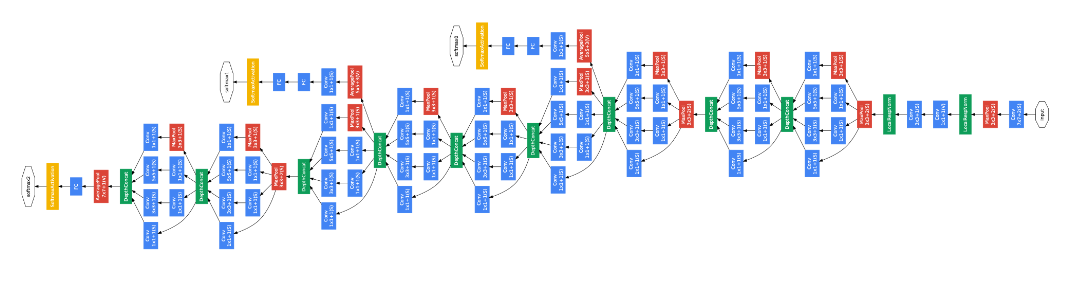

### 8.2.4 ResNet

스킵연결(skip connection): 층의 깊이에 비례해 성능을 향상시킨다.
입력 데이터를 합성곱 계층(weight layer)을 건너뛰어 출력에 바로 더하는 구조
역전파 때 스킵 연결이 신호 감쇠를 막아주기 때문에 층이 깊어져도 학습을 효율적으로 할 수 있다.

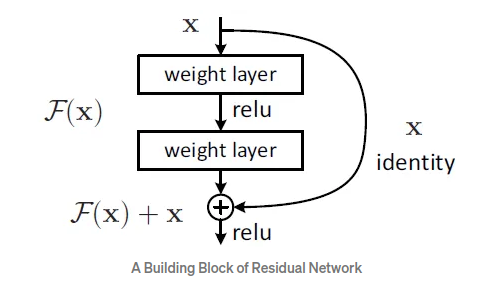

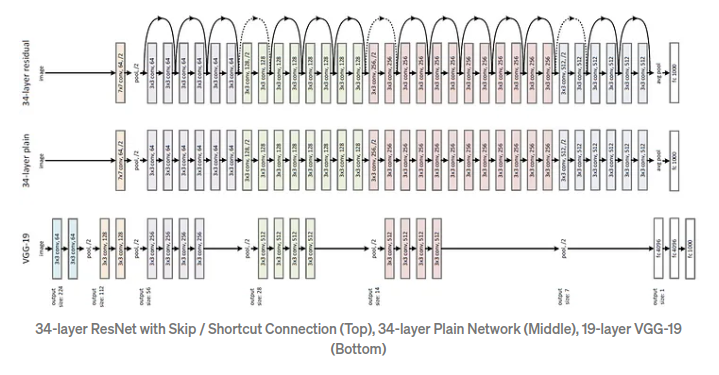

## 8.3 더 빠르게(딥러닝 고속화)


딥러닝 프레임워크 대부분은 GPU를 활용해 대량의 연산을 고속으로 처리할 수 있다.

### 8.3.1 풀어야할 숙제

딥러닝에서 어떠한 처리에 시간이 소요되는지 나타낸 그래프는 다음과 같다.

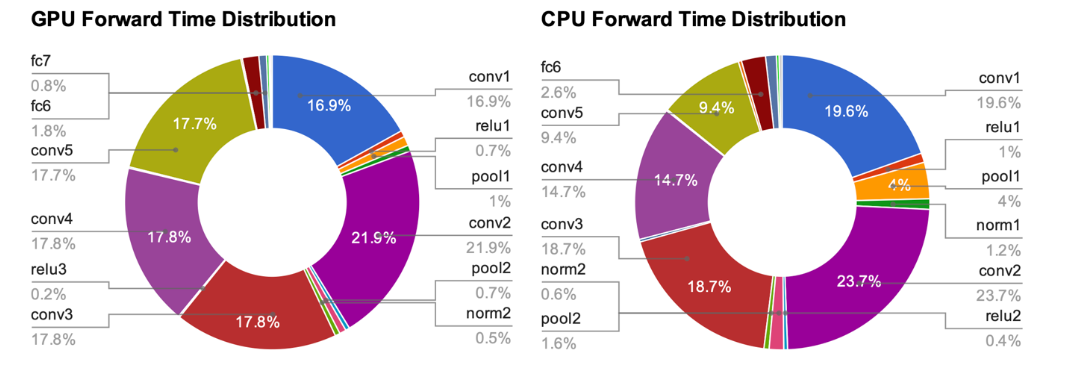

AlexNet에서는 오랜 시간을 합성곱 계층에서 소요한다. 그래서 합성곱 계층에서 이뤄지는 연산을 어떻게 고속으로 효율적으로 하느냐가 딥러닝의 과제라고 할 수 있다.

합성곱 함수를 어떻게 고속으로 처리하느냐가 관건임

### 8.3.2  GPU를 활용한 고속화

1. 계산 능력

  - 딥러닝 프레임워크 대부분은 GPU(Graphics Processing Unit)를 활용해 대량의 연산을 고속으로 처리한다.
  - GPU는 병렬 수치 연산을 고속으로 처리할 수 있다.
  - 딥러닝 계산을 더욱 고속화하고자 다수의 GPU와 기기로 계산을 분산한다.(딥러닝 학습의 수평 확장(scale out) 즉, 분산학습)
  - 다수의 GPU와 컴퓨터를 이용한 분산 학습을 지원한 딥러닝 프레임워크의 예
    - 구글-텐서플로
    - 마이크로소프트-CNTK(Computational Network Toolkit)

2. 메모리 용량
  - 대량의 가중치 매개변수와 중간 데이터를 메모리에 저장해야 한다.

3. 버스 대역폭
  - GPU(혹은 CPU)의 버스를 흐르는 데이터가 많아져 한계를 넘어서면 병목이 된다.


- 2와 3의 문제점을 해결하기 위해서는 네트워크로 주고받는 데이터의 비트 수를 최소로 만드는 것이 바람직하다.

- 신경망의 견고성: 딥러닝은 높은 수치 정밀도(수치를 몇 비트로 표현하느냐)를 요구하지 않는다.

### 8.3.3  분산 학습

딥러닝 계산을 더욱 고속화하고자 다수의 GPU와 기기로 계산을 분산하기도 한다.

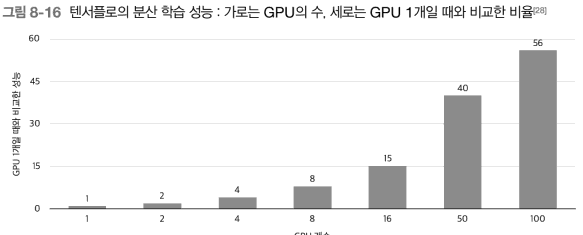

### 8.3.4 연산 정밀도와 비트 줄이기

half_float_network.py

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
#from deep_convnet import DeepConvNet
#from dataset.mnist import load_mnist


#(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
import tensorflow as tf
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255
x_train = x_train / 255
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 고속화를 위한 표본추출
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16(반정밀도)로 형변환
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))

caluculate accuracy (float64) ... 
0.9811
caluculate accuracy (float16) ... 
0.981


## 8.4 딥러닝의 활용

### 8.4.1 사물 검출


이미지 속에 담긴 사물의 위치와 종류(클래스)를 알아내는 기술

- R-CNN(Regions with Convolutional Neural Network)

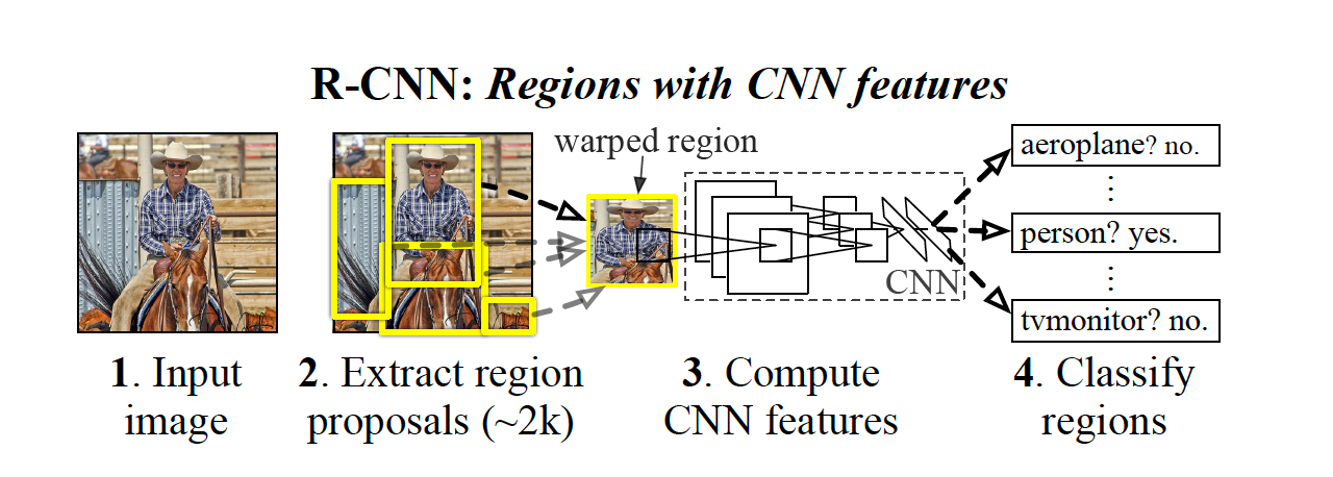

R-CNN 에서 주목할 곳은 2. 후보 영역 추출(사물처럼 보이는 물체를 찾아 처리) 과 3. CNN 특징 계산이다. 먼저 사물이 위치한 영역을 (어떤 방법으로) 찾아내고 추출한 각 영역에 CNN을 적용하여 클래스를 분류한다.

R-CNN논문에서는 Selective Search 기법을 사용했다.

### 8.4.2 분할(segmentation)

이미지를 픽셀 수준에서 분류한다.
픽셀 단위로 객체마다 채색된 지도(supervised) 데이터를 사용해 학습한다.

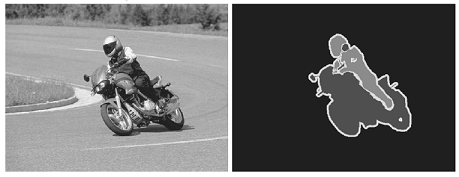

FCN(Fully Convolutional Network)
- 합성곱 계층만으로 구성된 네트워크.
- 단 한 번의 forward 처리로 모든 픽셀의 클래스를 분류해준다.

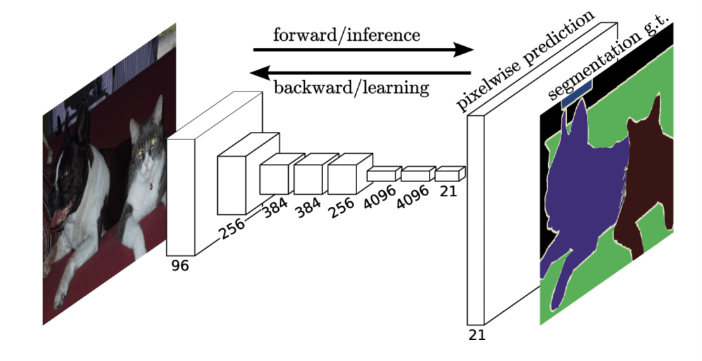

 공간 볼륨을 유지한 채 마지막 출력까지 처리할 수 있다.
- 마지막에 공간 크기를 확대하는 처리를 도입했다.
(이를 통해 줄어든 중간 데이터를 입력 이미지와 같은 크기까지 단번에 확대할 수 있다. 이중 선형 보간(bilinear interpolation)에 의한 선형 확대)

### 8.4.3 사진 캡션 생성

NIC(Neural Image Caption): 심층 CNN과 자연어를 다루는 순환신경망(Recurrent Neural Network)으로 구성된다.

RNN: 순환적 관계를 갖는 신경망으로 자연어나 시계열 데이터 등의 연속된 데이터를 다룰 때 많이 활용한다.

멀티모달 처리(multimodal processing): 사진이나 자연어와 같은 여러 종류의 정보를 조합하고 처리하는 것

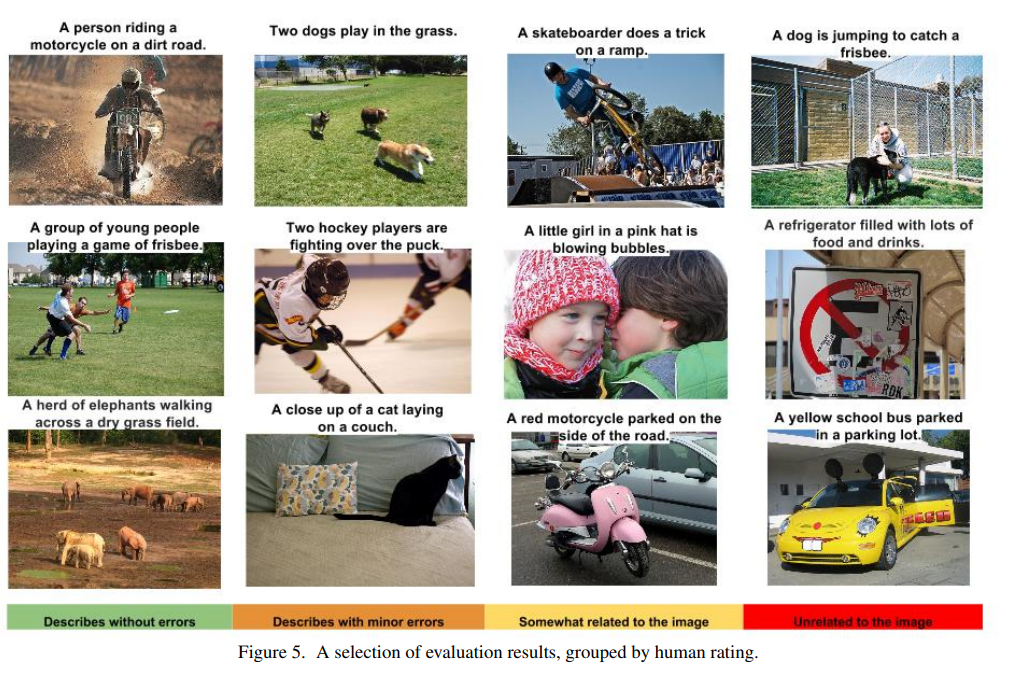

## 8.5 딥러닝의 미래

### 8.5.1 이미지 스타일(화풍) 변환

두 이미지(콘텐츠 이미지, 스타일 이미지)를 입력해서 새로운 그림을 생성하는 연구
논문
네트워크의 중간 데이터가 콘텐츠 이미지의 중간 데이터와 비슷해지도록 학습한다.
스타일 이미지의 화풍을 흡수하기 위해 스타일 행렬이라는 개념을 도입하고 스타일 행렬의 오차를 줄이도록 학습한다.

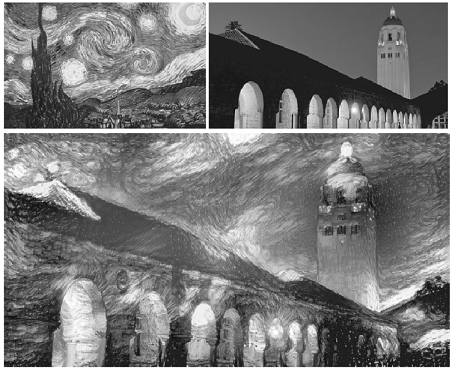

### 8.5.2 이미지 생성

DCGAN(Deep Convolutional Generative Adversarial Network)
- 이미지를 생성하는 과정을 모델화한다.
- 생성자(generator)와 식별자(discriminator)로 불리는 2개의 신경망을 이용한다.
- 생성자 는 진짜와 똑같은 이미지를 생성하고 식별자 는 그것이 진짜인지(생성 이미지인지, 촬영된 이미지인지)를 판정한다. 생성자와 식별자가 겨루도록 학습시켜 최종적으로 생성자는 진짜와 착각할 정도의 이미지를 그려낸다.

### 8.5.3 자율 주행

안전한 주행 영역을 올바로 인식(주위 환경 인식)

SegNet : CNN 기반 신경망. 입력 이미지를 분할(픽셀 수준에서 판정)한다.

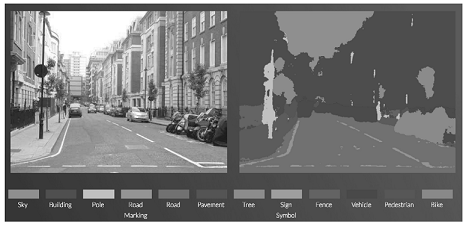

### 8.5.4 Deep Q-Network(강화학습)

강화학습에서는 에이전트가 환경에 맞게 행동을 선택하고 그 행동에 의해서 환경이 변한다는 게 기본적인 틀이다. 환경이 변화하면 에이전트는 어떠한 보상을 얻는데 강화학습의 목적은 더 나은 보상을 받는 쪽으로 에이전트의 행동 지침을 바로잡는 것이다.

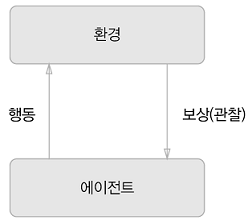

최적 행동 가치 함수로 최적인 행동을 정하는 Q학습이라는 강화학습 알고리즘을 기초로 한다. 최적 행동 가치 함수를 딥러닝(CNN)으로 비슷하게 흉내 내어 사용하는 것